In [48]:
from __future__ import annotations
import os
import numpy as np
import pandas as pd
from typing import Dict, Tuple, Optional, Iterable, List
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import networkx as nx

Carga de OTUS

In [49]:
def _try_read(path: str, sep, encoding=None) -> pd.DataFrame:
    return pd.read_csv(
        path, sep=sep, engine='python', comment='#', encoding=encoding
    )

def read_table_any(path: str) -> pd.DataFrame:
    """
    Lee TSV/CSV/espaciado con heurísticas de separador/encoding.
    No escribe archivos.
    """
    if os.path.isdir(path):
        raise ValueError(f"Recibí un directorio, no un archivo: {path}")
    seps = ['\t', ',', ';', r'\s+']
    encs = [None, 'utf-8', 'utf-8-sig', 'latin-1']
    last_err = None
    for enc in encs:
        for sep in seps:
            try:
                df = _try_read(path, sep=sep, encoding=enc)
                if df.shape[1] == 1:
                    try:
                        with open(path, 'r', encoding=enc or 'utf-8', errors='ignore') as fh:
                            txt = fh.read(2048)
                        if '\t' in txt and sep != '\t':
                            df = _try_read(path, sep='\t', encoding=enc)
                    except Exception:
                        pass
                return df
            except Exception as e:
                last_err = e
    raise ValueError(f"No pude leer {path}. Último error: {last_err}")

def load_otu_table(path_otus: str, verbose: bool=True) -> pd.DataFrame:
    """
    Devuelve OTU con forma (OTUs x Muestras) en float, sin columnas vacías.
    NO genera archivos.
    """
    if os.path.isdir(path_otus):
        raise ValueError(f"Recibí un directorio, no un archivo: {path_otus}")
    df = read_table_any(path_otus)

    otu_id_col = None
    for cand in ['#OTU ID','OTU ID','OTU','Otu','otu','Feature ID','FeatureID']:
        if cand in df.columns:
            otu_id_col = cand
            break
    if otu_id_col is None:
        if not np.issubdtype(df.dtypes.iloc[0], np.number):
            otu_id_col = df.columns[0]
    if otu_id_col is not None:
        df = df.set_index(otu_id_col)

    if 'taxonomy' in df.columns:
        df = df.drop(columns=['taxonomy'])

    df = df.apply(pd.to_numeric, errors='coerce').fillna(0.0)

    # Queremos (OTUs x Muestras)
    if df.shape[0] < df.shape[1]:
        df = df.T

    if df.shape[0] > 0 and df.shape[1] > 0:
        df = df.loc[df.sum(axis=1) > 0, :]
        df = df.loc[:, df.sum(axis=0) > 0]

    df.columns = df.columns.astype(str)

    if verbose:
        print("load_otu_table => shape (OTUs x Muestras):", df.shape)
        print("Muestras con suma>0:", int((df.sum(axis=0) > 0).sum()))
        print("OTUs con suma>0:", int((df.sum(axis=1) > 0).sum()))
    if df.shape[1] == 0:
        raise ValueError(
            "La tabla se leyó pero quedó sin columnas (muestras=0). "
            "Asegura separador TAB y header con IDs de muestras."
        )
    return df

SubMuestreo

In [50]:
def subsample_otu(OTU: pd.DataFrame, 
                  max_samples: Optional[int]=None, sample_frac: Optional[float]=None,
                  max_otus: Optional[int]=None,  otus_frac: Optional[float]=None,
                  seed: int=42,
                  drop_empty_samples: bool=True, drop_empty_otus: bool=True,
                  min_sample_sum: float=0.0, min_otu_sum: float=0.0,
                  verbose: bool=True) -> pd.DataFrame:
    """
    Submuestrea filas (OTUs) y columnas (muestras) con parámetros.
    NO escribe archivos.
    """
    rng = np.random.default_rng(seed)

    sample_cols = OTU.columns.to_numpy()
    if max_samples is not None:
        max_samples = int(max_samples)
        if max_samples < len(sample_cols):
            sample_cols = rng.choice(sample_cols, size=max_samples, replace=False)
    elif sample_frac is not None:
        n_keep = max(2, int(np.ceil(len(sample_cols) * float(sample_frac))))
        sample_cols = rng.choice(sample_cols, size=n_keep, replace=False)

    otu_rows = OTU.index.to_numpy()
    if max_otus is not None:
        max_otus = int(max_otus)
        if max_otus < len(otu_rows):
            otu_rows = rng.choice(otu_rows, size=max_otus, replace=False)
    elif otus_frac is not None:
        m_keep = max(10, int(np.ceil(len(otu_rows) * float(otus_frac))))
        otu_rows = rng.choice(otu_rows, size=m_keep, replace=False)

    OTU_sub = OTU.loc[otu_rows, sample_cols]

    if drop_empty_otus:
        OTU_sub = OTU_sub.loc[OTU_sub.sum(axis=1) > min_otu_sum]
    if drop_empty_samples:
        OTU_sub = OTU_sub.loc[:, OTU_sub.sum(axis=0) > min_sample_sum]

    if verbose:
        print("subsample_otu => shape (OTUs x Muestras):", OTU_sub.shape)
        print("Muestras con suma>0:", int((OTU_sub.sum(axis=0) > min_sample_sum).sum()))
        print("OTUs con suma>0:", int((OTU_sub.sum(axis=1) > min_otu_sum).sum()))
    return OTU_sub

Diversidad y Similitud

In [51]:
def alpha_metrics_from_counts(otu_counts_col: pd.Series) -> Dict[str, float]:
    x = otu_counts_col.values.astype(float)
    present = x > 0
    S = present.sum()
    N = x.sum()
    if N <= 0 or S == 0:
        return dict(richness=0, shannon=0.0, simpson_1m0=0.0, pielou=0.0, chao1=0.0)
    p = x[present] / x[present].sum()
    H = -np.sum(p * np.log(p + 1e-12))        # Shannon
    D = np.sum(p**2)                           # Simpson
    simpson_1m0 = 1.0 - D
    pielou = H / np.log(max(S,1))
    f1 = np.sum(x[present] == 1)
    f2 = np.sum(x[present] == 2)
    if f2 > 0:
        chao1 = S + (f1*(f1-1))/(2*(f2+1e-12))
    else:
        chao1 = S + (f1*(f1-1))/2.0
    return dict(richness=S, shannon=H, simpson_1m0=simpson_1m0, pielou=pielou, chao1=chao1)

def compute_alpha_table(OTU: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for sample in OTU.columns:
        met = alpha_metrics_from_counts(OTU[sample])
        met['sample_id'] = sample
        rows.append(met)
    return pd.DataFrame(rows).set_index('sample_id')

def _row_l2_normalize(Z: np.ndarray) -> np.ndarray:
    norms = np.linalg.norm(Z, axis=1, keepdims=True)
    norms = np.where(norms == 0.0, 1.0, norms)
    return Z / norms

def alpha_similarity(alpha_df: pd.DataFrame,
                     use_cols: Iterable[str]=('richness','shannon','simpson_1m0','pielou','chao1'),
                     topk: int=20) -> csr_matrix:
    cols = [c for c in use_cols if c in alpha_df.columns]
    A = alpha_df[cols].copy()
    mu = A.mean(axis=0).to_numpy()
    sd = A.std(axis=0, ddof=0).replace(0, 1.0).to_numpy()
    Z = (A.to_numpy() - mu) / sd
    Z = _row_l2_normalize(Z)
    K = Z @ Z.T
    np.fill_diagonal(K, 0.0)
    return topk_sym(K, topk)

def ppmi_matrix(B: np.ndarray) -> np.ndarray:
    S = B.sum()
    if S <= 0:
        return np.zeros_like(B, dtype=float)
    p_if = B / S
    p_i  = p_if.sum(axis=1, keepdims=True)
    p_f  = p_if.sum(axis=0, keepdims=True)
    PMI = np.log((p_if + 1e-12) / (p_i @ p_f + 1e-12))
    return np.maximum(PMI, 0.0)

def similarity_from_ppmi(B: np.ndarray, topk: int=20) -> csr_matrix:
    P = ppmi_matrix(B)              # N x F
    K = P @ P.T                     # N x N
    np.fill_diagonal(K, 0.0)
    return topk_sym(K, topk)

def clr_transform_counts(OTU: pd.DataFrame, pseudo: float=0.5) -> np.ndarray:
    X = OTU.T.astype(float).to_numpy() + pseudo   # (N, F)
    row_sums = X.sum(axis=1, keepdims=True)
    row_sums = np.where(row_sums == 0.0, 1.0, row_sums)
    X = X / row_sums
    logX = np.log(X)
    gm = logX.mean(axis=1, keepdims=True)
    clr = logX - gm
    return clr                                    # (N, F)

def similarity_from_clr_dot(OTU: pd.DataFrame, topk: int=20, pseudo: float=0.5) -> csr_matrix:
    Z = clr_transform_counts(OTU, pseudo=pseudo)
    Z = _row_l2_normalize(Z)
    K = Z @ Z.T
    np.fill_diagonal(K, 0.0)
    return topk_sym(K, topk)

def topk_sym(K: np.ndarray, k: int) -> csr_matrix:
    N = K.shape[0]
    k = min(k, max(1, N-1))
    rows, cols, data = [], [], []
    for i in range(N):
        if k >= N:
            idx = np.arange(N)
        else:
            idx = np.argpartition(-K[i], kth=k-1)[:k]
        v = K[i, idx]
        rows += [i]*len(idx); cols += idx.tolist(); data += v.tolist()
    W = csr_matrix((data,(rows,cols)), shape=K.shape).tolil()
    W = (W + W.T) * 0.5
    return W.tocsr()

Kuramoto

In [52]:
def kuramoto_sim(W: csr_matrix, K_g: float,
                 omega: Optional[np.ndarray]=None, alpha: float=0.0,
                 dt: float=0.02, T: int=2000, burn: int=800, seed: int=0) -> np.ndarray:
    rng = np.random.default_rng(seed)
    N = W.shape[0]
    if omega is None:
        omega = np.zeros(N)
    theta = rng.uniform(-np.pi, np.pi, size=N)
    W = W.tocsr()
    keep = []
    for t in range(T):
        s = np.sin(theta - alpha); c = np.cos(theta - alpha)
        Ws = W.dot(s); Wc = W.dot(c)
        coupling = Ws*np.cos(theta) - Wc*np.sin(theta)
        dtheta = omega + K_g*coupling
        theta = (theta + dt*dtheta + 2*np.pi) % (2*np.pi)
        if t >= burn:
            keep.append(theta.copy())
    return np.stack(keep, axis=0)  # (T_eff x N)

def phase_affinity(Theta: np.ndarray, chunk: int=4096) -> np.ndarray:
    T, N = Theta.shape
    A = np.zeros((N,N), dtype=np.float64)
    for i0 in range(0, N, chunk):
        i1 = min(N, i0+chunk)
        d = Theta[:, i0:i1, None] - Theta[:, None, :]
        A[i0:i1, :] = np.cos(d).mean(axis=0)
    A = (A + A.T)/2
    np.fill_diagonal(A, 1.0)
    return A

Clustering

In [53]:
def affinity_to_graph_topk(A: np.ndarray, topk: int=10) -> List[Tuple[int,int,float]]:
    N = A.shape[0]
    np.fill_diagonal(A, 0.0)
    keep = set()
    for i in range(N):
        idx = np.argpartition(-A[i], kth=min(topk, N-1))[:topk]
        for j in idx:
            if i != j:
                keep.add(tuple(sorted((i, j))))
    edges = [(i, j, float(A[i, j])) for (i, j) in keep]
    return edges

def leiden_clusters_from_affinity(A: np.ndarray, topk: int=10, resolution: float=1.0, n_iter: int=2, seed: int=0):
    try:
        import igraph as ig
        import leidenalg as la
    except Exception as e:
        raise RuntimeError("Instala 'python-igraph' y 'leidenalg' para usar Leiden.") from e

    edges = affinity_to_graph_topk(A.copy(), topk=topk)
    if not edges:
        raise ValueError("La afinidad no produjo aristas. Revisa topk o A.")
    N = A.shape[0]
    g = ig.Graph()
    g.add_vertices(N)
    g.add_edges([(i, j) for (i, j, _) in edges])
    g.es['weight'] = [w for (_, _, w) in edges]

    part = la.find_partition(
        g,
        la.RBConfigurationVertexPartition,
        weights='weight',
        resolution_parameter=resolution,
        seed=seed,
        n_iterations=n_iter
    )
    labels = np.array(part.membership, dtype=int)
    Q = g.modularity(part, weights='weight')
    return labels, Q

def louvain_clusters_from_affinity(A: np.ndarray, topk: int=10):
    try:
        import community as community_louvain  # python-louvain
    except Exception as e:
        raise RuntimeError("Instala 'python-louvain' o usa label_propagation.") from e

    edges = affinity_to_graph_topk(A.copy(), topk=topk)
    G = nx.Graph()
    for i, j, w in edges:
        G.add_edge(i, j, weight=float(w))
    part = community_louvain.best_partition(G, weight='weight', random_state=0)
    labels = np.array([part[i] for i in range(G.number_of_nodes())], dtype=int)
    Q = community_louvain.modularity(part, G, weight='weight')
    return labels, Q

def labelprop_clusters_from_affinity(A: np.ndarray, topk: int=10):
    edges = affinity_to_graph_topk(A.copy(), topk=topk)
    G = nx.Graph()
    for i, j, w in edges:
        G.add_edge(i, j, weight=float(w))
    communities = nx.algorithms.community.asyn_lpa_communities(G, weight='weight', seed=0)
    labels = np.empty(G.number_of_nodes(), dtype=int)
    for cid, comm in enumerate(communities):
        for node in comm:
            labels[node] = cid
    Q = None
    return labels, Q

Experimentacion

In [54]:
def build_fused_graph(OTU: pd.DataFrame,
                      weights: Dict[str, float]=dict(alpha=0.4, ppmi=0.4, clr=0.2),
                      topk: int=12) -> Tuple[csr_matrix, pd.DataFrame]:
    alpha_df = compute_alpha_table(OTU)
    W_alpha = alpha_similarity(alpha_df, topk=topk)

    B = OTU.T.values.astype(float)   # N x F
    W_ppmi = similarity_from_ppmi(B, topk=topk)
    W_clr  = similarity_from_clr_dot(OTU, topk=topk, pseudo=0.5)

    comps = []
    if weights.get('alpha',0)>0: comps.append((weights['alpha'], W_alpha))
    if weights.get('ppmi',0)>0:  comps.append((weights['ppmi'],  W_ppmi))
    if weights.get('clr',0)>0:   comps.append((weights['clr'],   W_clr))

    N = OTU.shape[1]
    Ksum = np.zeros((N,N), dtype=float)
    for w,W in comps:
        Ksum += w * W.toarray()
    np.fill_diagonal(Ksum, 0.0)
    W_fused = topk_sym(Ksum, topk)
    return W_fused, alpha_df.reset_index().rename(columns={'index':'sample_id'})

def run_experiment_from_otus(
    path_otus: str,
    max_samples: Optional[int]=40, sample_frac: Optional[float]=None,
    max_otus: Optional[int]=800,  otus_frac: Optional[float]=None,
    seed: int=7,
    drop_empty_samples: bool=True, drop_empty_otus: bool=True,
    min_sample_sum: float=0.0, min_otu_sum: float=0.0,
    topk: int=10,
    weights: Dict[str,float]=dict(alpha=0.4, ppmi=0.4, clr=0.2),
    K_sweep: Iterable[float]=np.geomspace(0.4, 3.0, 5),
    dt: float=0.02, T: int=1800, burn: int=700,
    clustering: str="auto",
    leiden_resolution: float=1.0,
    verbose: bool=True
):
    """
    Ejecuta TODO en memoria y RETORNA resultados (NO escribe archivos).
    Devuelve: labels (np.ndarray), alpha_df (pd.DataFrame con sample_id),
              grid_df (pd.DataFrame con columnas Kg, Q, k, method),
              subset_shape (tupla).
    """
    OTU_full = load_otu_table(path_otus, verbose=verbose)

    OTU = subsample_otu(
        OTU_full,
        max_samples=max_samples, sample_frac=sample_frac,
        max_otus=max_otus, otus_frac=otus_frac, seed=seed,
        drop_empty_samples=drop_empty_samples, drop_empty_otus=drop_empty_otus,
        min_sample_sum=min_sample_sum, min_otu_sum=min_otu_sum,
        verbose=verbose
    )
    N = OTU.shape[1]
    if N < 3:
        raise ValueError(f"Muy pocas muestras tras submuestreo: N={N}. Ajusta parámetros.")

    topk_eff = min(topk, max(1, N-1))
    W, alpha_df = build_fused_graph(OTU, weights=weights, topk=topk_eff)

    scored = []
    for Kg in K_sweep:
        Theta = kuramoto_sim(W, Kg, omega=np.zeros(N), dt=dt, T=T, burn=burn, seed=seed)
        Aphase = phase_affinity(Theta)

        method_used, labels, Q = None, None, None
        if clustering == "leiden":
            labels, Q = leiden_clusters_from_affinity(Aphase, topk=min(10,N-1),
                                                      resolution=leiden_resolution, n_iter=2, seed=seed)
            method_used = "leiden"
        elif clustering == "louvain":
            labels, Q = louvain_clusters_from_affinity(Aphase, topk=min(10,N-1))
            method_used = "louvain"
        elif clustering == "labelprop":
            labels, Q = labelprop_clusters_from_affinity(Aphase, topk=min(10,N-1))
            method_used = "labelprop"
        else:  # auto
            try:
                labels, Q = leiden_clusters_from_affinity(Aphase, topk=min(10, N-1),
                                                          resolution=leiden_resolution, n_iter=2, seed=seed)
                method_used = "leiden"
            except Exception:
                try:
                    labels, Q = louvain_clusters_from_affinity(Aphase, topk=min(10,N-1))
                    method_used = "louvain"
                except Exception:
                    labels, Q = labelprop_clusters_from_affinity(Aphase, topk=min(10,N-1))
                    method_used = "labelprop"

        k_found = int(len(np.unique(labels)))
        scored.append({'Kg': float(Kg), 'Q': (float(Q) if Q is not None else -1e9),
                       'k': k_found, 'method': method_used, 'labels': labels})

    # Elige por máxima modularidad
    best = max(scored, key=lambda r: r['Q'])
    best_labels = np.asarray(best['labels'], dtype=int)
    grid_df = pd.DataFrame([{k: v for k,v in d.items() if k!='labels'} for d in scored]).sort_values('Kg')

    if verbose:
        print(f"Mejor Kg={best['Kg']:.4f} con Q={best['Q']:.4f} vía {best['method']} k={best['k']}")

    labels_df = pd.DataFrame({'sample_id': OTU.columns.tolist(), 'cluster': best_labels})
    return best_labels, labels_df, alpha_df, grid_df, OTU.shape

Grafo

In [55]:
def _node_sizes_from_metric(G: nx.Graph, df_sizes: Optional[pd.DataFrame], metric="shannon"):
    if df_sizes is None or metric not in (df_sizes.columns if df_sizes is not None else []):
        return 300
    vals = df_sizes.set_index("sample_id")[metric]
    vals = (vals - vals.min()) / (vals.max() - vals.min() + 1e-12)
    return [200 + 800*float(vals.get(n, 0.5)) for n in G.nodes]

def _node_colors_by_cluster(G: nx.Graph):
    import itertools
    clusters = sorted({G.nodes[n].get("cluster", -1) for n in G.nodes})
    base = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple",
            "tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan"]
    cyc = itertools.cycle(base)
    cmap = {c: next(cyc) for c in clusters}
    return [cmap.get(G.nodes[n].get("cluster", -1), "tab:gray") for n in G.nodes]

def build_graph_alpha_similarity(labels_df: pd.DataFrame, alpha_df: pd.DataFrame, topk: int=8) -> Tuple[nx.Graph, pd.DataFrame]:
    df = alpha_df.merge(labels_df, on="sample_id", how="inner").sort_values("sample_id")
    alpha_cols = [c for c in ["richness","shannon","simpson_1m0","pielou","chao1"] if c in df.columns]
    if not alpha_cols:
        raise ValueError("No encontré métricas alfa estándar en alpha_df")
    X = df[alpha_cols].to_numpy().astype(float)
    mu = X.mean(axis=0, keepdims=True); sd = X.std(axis=0, ddof=0, keepdims=True)
    sd = np.where(sd==0.0, 1.0, sd)
    Z = (X - mu) / sd
    Z = _row_l2_normalize(Z)
    K = Z @ Z.T
    np.fill_diagonal(K, 0.0)

    N = K.shape[0]
    edges = set()
    for i in range(N):
        k_eff = min(topk, max(1, N-1))
        idx = np.argpartition(-K[i], kth=k_eff-1)[:k_eff]
        for j in idx:
            if i != j:
                edges.add(tuple(sorted((i, j))))

    G = nx.Graph()
    for _, r in df.iterrows():
        G.add_node(str(r["sample_id"]), cluster=int(r["cluster"]))
    sids = df["sample_id"].astype(str).tolist()
    for i, j in edges:
        G.add_edge(sids[i], sids[j], weight=float(K[i, j]))
    return G, df

def layout_spectral(G: nx.Graph, seed: int=7):
    try:
        return nx.spectral_layout(G, random_state=seed, weight="weight", dim=2)
    except TypeError:
        np.random.seed(seed)
        return nx.spectral_layout(G)

def layout_clustered(G: nx.Graph, seed: int=7):
    clusters = sorted({G.nodes[n]['cluster'] for n in G.nodes})
    R = 5.0
    pos_clusters = {
        c: np.array([R*np.cos(2*np.pi*k/len(clusters)),
                     R*np.sin(2*np.pi*k/len(clusters))])
        for k, c in enumerate(clusters)
    }
    clust2nodes = {c: [n for n in G.nodes if G.nodes[n]['cluster']==c] for c in clusters}

    pos = {}
    for c, nodes in clust2nodes.items():
        sub = G.subgraph(nodes).copy()
        try:
            pos_local = nx.spring_layout(sub, seed=seed, weight="weight", k=None, iterations=100)
        except TypeError:
            pos_local = nx.spring_layout(sub, random_state=seed, weight="weight", k=None, iterations=100)
        P = np.array(list(pos_local.values()))
        if len(P):
            P = (P - P.mean(axis=0))
            denom = np.max(np.linalg.norm(P, axis=1))
            if denom > 0: P = P / denom
            P *= 1.4
            for n, p in zip(sub.nodes(), P):
                pos[n] = pos_clusters[c] + p
    for n in G.nodes:
        if n not in pos:
            pos[n] = pos_clusters[G.nodes[n]['cluster']].copy()
    return pos

def phase_layout_from_otus(path_otus: str, labels_df: pd.DataFrame, topk: int=8, seed: int=7):
    # Usa CLR-dot para pesos y simula una sola vez (K fijo razonable)
    OTU = load_otu_table(path_otus, verbose=False)
    want = labels_df['sample_id'].astype(str).tolist()
    missing = [w for w in want if w not in OTU.columns]
    if missing:
        raise ValueError(f"Muestras del labels no están en OTU (primeras): {missing[:5]}")
    OTU = OTU.loc[:, want]

    Z = clr_transform_counts(OTU)
    Z = _row_l2_normalize(Z)
    K = Z @ Z.T
    np.fill_diagonal(K, 0.0)

    # top-k
    N = K.shape[0]; E=set()
    for i in range(N):
        kk=min(topk, max(1,N-1))
        idx=np.argpartition(-K[i], kth=kk-1)[:kk]
        for j in idx:
            if i!=j: E.add(tuple(sorted((i,j))))
    sids = OTU.columns.astype(str).tolist()
    idxmap = {s:i for i,s in enumerate(sids)}
    W = np.zeros((N,N))
    for i,j in E:
        W[i,j] = W[j,i] = K[i,j]

    # simula con Kg medio
    Kg = 1.0
    rng = np.random.default_rng(seed)
    theta = rng.uniform(-np.pi, np.pi, size=N)
    T, burn, dt = 1200, 500, 0.02
    keep=[]
    for t in range(T):
        s=np.sin(theta); c=np.cos(theta)
        Ws=W@s; Wc=W@c
        coupling = Ws*np.cos(theta) - Wc*np.sin(theta)
        theta = (theta + dt*(Kg*coupling) + 2*np.pi) % (2*np.pi)
        if t>=burn: keep.append(theta.copy())
    Theta = np.stack(keep, axis=0)
    phi = np.angle(np.exp(1j*Theta).mean(axis=0))
    pos = {sids[i]: np.array([np.cos(phi[i]), np.sin(phi[i])]) for i in range(len(sids))}
    return pos

def draw_graph(G: nx.Graph, pos: Dict[str, np.ndarray],
               df_sizes: Optional[pd.DataFrame]=None, metric: str="shannon",
               title: str="", show: bool=True,
               save_path: Optional[str]=None, dpi: int=160):
    colors = _node_colors_by_cluster(G)
    sizes  = _node_sizes_from_metric(G, df_sizes, metric)
    plt.figure(figsize=(9,7))
    nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors,
                           alpha=0.9, linewidths=0.5, edgecolors='white')
    nx.draw_networkx_edges(G, pos,
                           width=[0.5+2.0*G[u][v].get("weight",0.0) for u,v in G.edges()],
                           alpha=0.45)
    # nx.draw_networkx_labels(G, pos, font_size=7)
    plt.title(title); plt.axis("off"); plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close()

def make_graph_from_results(
    labels_df: pd.DataFrame,
    alpha_df: pd.DataFrame,
    mode: str="spectral",           # "spectral" | "clustered" | "phase"
    path_otus_for_phase: Optional[str]=None,
    topk_alpha: int=8,
    node_size_metric: str="shannon",
    seed: int=7,
    show: bool=True,
    save_path: Optional[str]=None
):
    """
    Construye el grafo (por similitud ALFA) y aplica un LAYOUT "más fiel":
    - spectral: embedding por Laplaciano
    - clustered: islas por cluster + fuerzas internas
    - phase: re-posiciona por fase media (requiere path_otus_for_phase)
    """
    G, df_sizes = build_graph_alpha_similarity(labels_df, alpha_df, topk=topk_alpha)

    if mode.lower()=="spectral":
        pos = layout_spectral(G, seed=seed)
        ttl = "Grafo (layout espectral del Laplaciano)"
    elif mode.lower()=="clustered":
        pos = layout_clustered(G, seed=seed)
        ttl = "Grafo (clusters en islas + fuerzas internas)"
    elif mode.lower()=="phase":
        if not path_otus_for_phase:
            raise ValueError("Para mode='phase' debes pasar path_otus_for_phase")
        pos = phase_layout_from_otus(path_otus_for_phase, labels_df, topk=topk_alpha, seed=seed)
        ttl = "Grafo (posición por fase media de Kuramoto)"
    else:
        raise ValueError("mode debe ser 'spectral', 'clustered' o 'phase'")

    draw_graph(G, pos, df_sizes=df_sizes, metric=node_size_metric,
               title=ttl, show=show, save_path=save_path)

Graficas de Resumen

In [56]:
def plot_counts(labels_df: pd.DataFrame, show: bool=True, save_path: Optional[str]=None, dpi: int=150):
    plt.figure(figsize=(6,4))
    labels_df['cluster'].value_counts().sort_index().plot(kind='bar')
    plt.title("Número de muestras por cluster")
    plt.xlabel("Cluster"); plt.ylabel("N muestras"); plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    if show: plt.show()
    else: plt.close()

def plot_alpha_boxplots(alpha_df: pd.DataFrame, labels_df: pd.DataFrame,
                        show: bool=True, save_dir: Optional[str]=None, dpi: int=150):
    df = alpha_df.merge(labels_df, on='sample_id', how='left')
    metrics = [m for m in ['richness','shannon','simpson_1m0','pielou','chao1'] if m in df.columns]
    clusters = sorted(df['cluster'].dropna().unique().tolist())

    if not metrics or not clusters:
        return
    for metric in metrics:
        plt.figure(figsize=(7,4))
        data = [df.loc[df['cluster']==c, metric].dropna().values for c in clusters]
        plt.boxplot(data, labels=[str(c) for c in clusters], showmeans=True)
        plt.title(f"{metric} por cluster"); plt.xlabel("Cluster"); plt.ylabel(metric); plt.tight_layout()
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            plt.savefig(os.path.join(save_dir, f"alpha_{metric}_by_cluster.png"), dpi=dpi, bbox_inches='tight')
        if show: plt.show()
        else: plt.close()

def plot_grid_curves(grid_df: pd.DataFrame, show: bool=True, save_dir: Optional[str]=None, dpi: int=150):
    if 'Kg' not in grid_df.columns or 'Q' not in grid_df.columns:
        return
    gmax = grid_df.groupby('Kg', as_index=False).agg({'Q':'max','k':'max'}).sort_values('Kg')

    plt.figure(figsize=(7,4))
    plt.plot(gmax['Kg'], gmax['Q'], marker='o')
    plt.title("Modularidad Q vs K_g"); plt.xlabel("K_g"); plt.ylabel("Q"); plt.tight_layout()
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, "Q_vs_Kg.png"), dpi=dpi, bbox_inches='tight')
    if show: plt.show()
    else: plt.close()

    if 'k' in gmax.columns:
        plt.figure(figsize=(7,4))
        plt.bar(gmax['Kg'].astype(str), gmax['k'])
        plt.title("Número de clusters (k) vs K_g"); plt.xlabel("K_g"); plt.ylabel("k"); plt.tight_layout()
        if save_dir:
            plt.savefig(os.path.join(save_dir, "k_vs_Kg.png"), dpi=dpi, bbox_inches='tight')
        if show: plt.show()
        else: plt.close()

def plot_alpha_means(alpha_df: pd.DataFrame, labels_df: pd.DataFrame,
                     show: bool=True, save_path: Optional[str]=None, dpi: int=150):
    df = alpha_df.merge(labels_df, on='sample_id', how='left')
    metrics = [m for m in ['richness','shannon','simpson_1m0','pielou','chao1'] if m in df.columns]
    if not metrics: return
    means = df.groupby('cluster')[metrics].mean().sort_index()
    errs  = df.groupby('cluster')[metrics].sem().sort_index()

    plt.figure(figsize=(8,5))
    x = np.arange(len(means.index)); w = 0.13
    for i, m in enumerate(metrics):
        plt.bar(x + (i - len(metrics)/2)*w + w/2, means[m].values, width=w, yerr=errs[m].values, capsize=3, label=m)
    plt.xticks(x, means.index.astype(str))
    plt.title("Promedios de diversidad alfa por cluster (±SEM)")
    plt.xlabel("Cluster"); plt.ylabel("Valor"); plt.legend(frameon=False); plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    if show: plt.show()
    else: plt.close()

Parametros

load_otu_table => shape (OTUs x Muestras): (4720, 441)
Muestras con suma>0: 441
OTUs con suma>0: 4720
subsample_otu => shape (OTUs x Muestras): (415, 100)
Muestras con suma>0: 100
OTUs con suma>0: 415
Mejor Kg=0.4000 con Q=-1000000000.0000 vía labelprop k=5


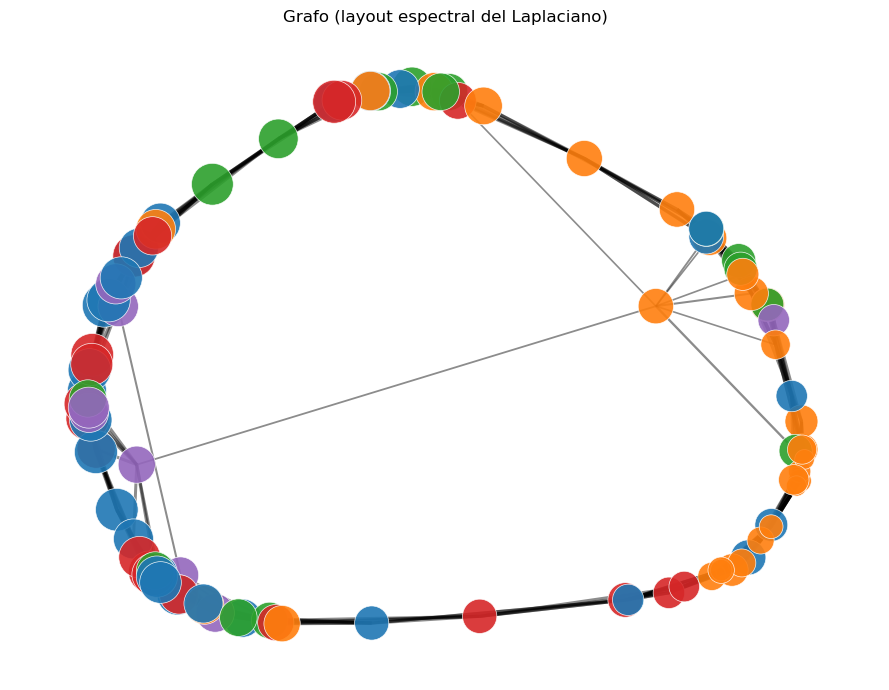

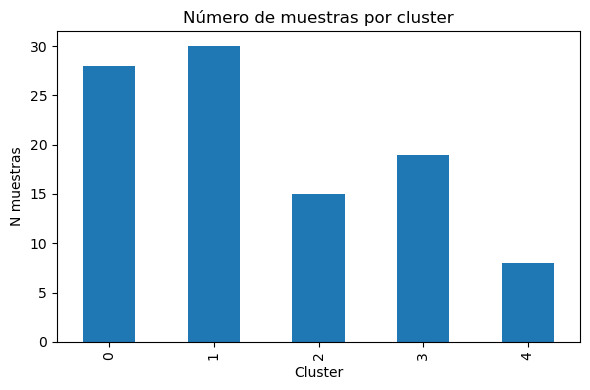

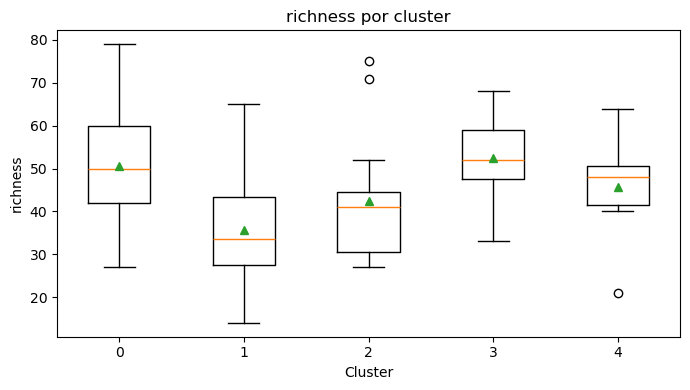

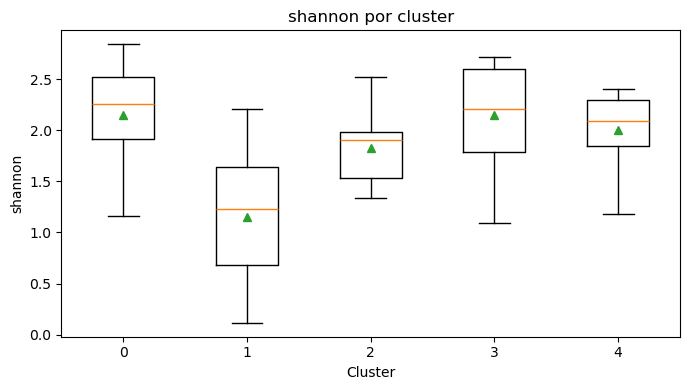

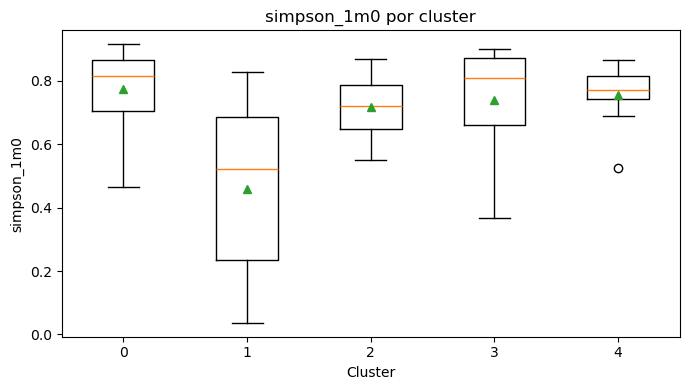

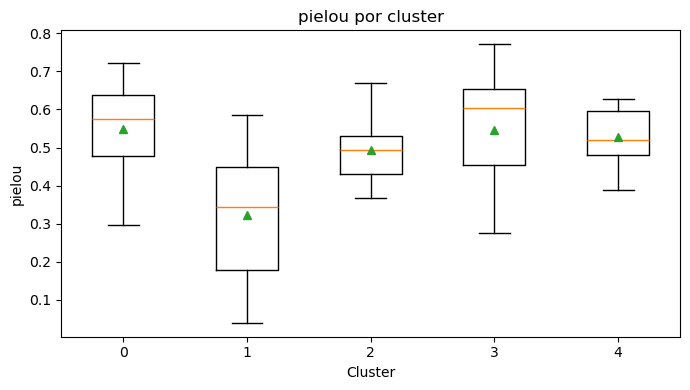

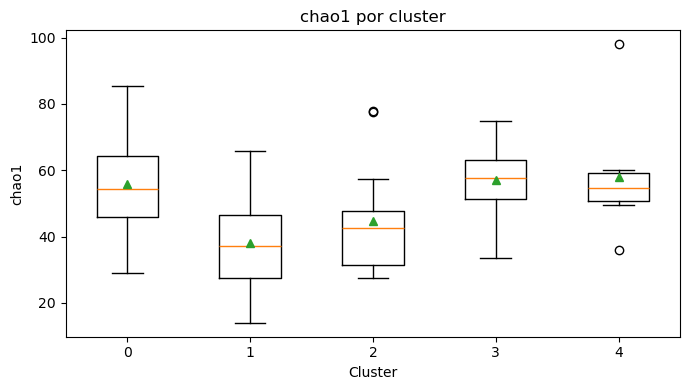

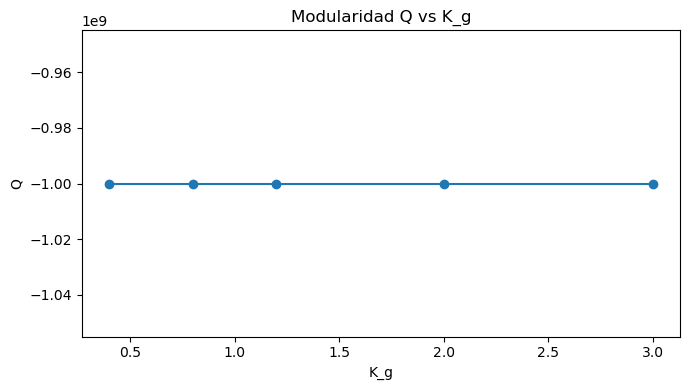

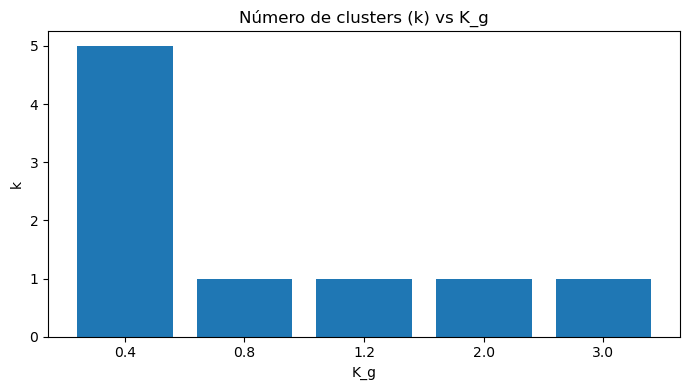

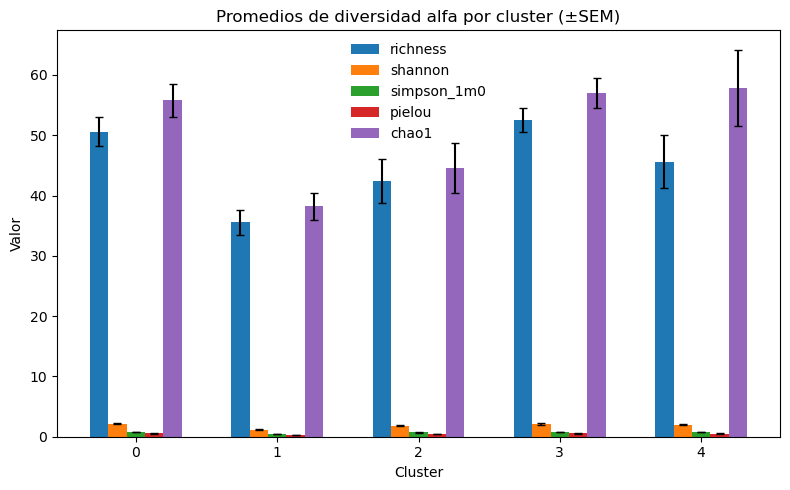

In [57]:
# 1) Ejecutar el experimento en memoria (SIN CSV/PNG)
labels, labels_df, alpha_df, grid_df, subset_shape = run_experiment_from_otus(
    path_otus=r"C:\Users\C N T\OneDrive - Universidad de los andes\Investigacion_Microbiota\Datos\otu_data.otus",   # <-- se pasa por variable
    max_samples=100, max_otus=800, seed=11,
    topk=10, weights=dict(alpha=0.4, ppmi=0.4, clr=0.2),
    K_sweep=[0.4, 0.8, 1.2, 2.0, 3.0],      # parametrizable
    dt=0.02, T=1200, burn=500,
    clustering="auto",                      # "leiden" | "louvain" | "labelprop" | "auto"
    leiden_resolution=1.0,
    verbose=True
)

# 2) Grafo "más fiel" (no guarda, solo muestra; puedes pasar save_path si quieres)
make_graph_from_results(
    labels_df, alpha_df,
    mode="spectral",             # "spectral" | "clustered" | "phase"
    path_otus_for_phase=None,    # requerid@ si mode="phase"
    topk_alpha=8,
    node_size_metric="shannon",
    seed=7,
    show=True,
    save_path=None               # e.g. r"D:\salidas\grafo.png"
)

# 3) Plots de resumen (solo display por defecto)
plot_counts(labels_df)
plot_alpha_boxplots(alpha_df, labels_df)
plot_grid_curves(grid_df)
plot_alpha_means(alpha_df, labels_df)